# Residential Energy Performance Scoring

Energy Star used CBECS(US) and SCIEU(Canada) datasets to understand the energy usage in public buildings and develop tranditional 1-100 ENERGY STAR rating for commercial and institutional buildings. Similarly, the governments also surveyed RECS(US) and SECMURB(Canada) to samples energy usage in residential buildings. Unfortunately, SECMURB is not available, and we perform analysis on RECS by applying similar scoring mechanism on the dataset. 

RECS is sampled every four year, here we uses 2015. 

Description: https://www.eia.gov/consumption/residential/

Data: https://www.eia.gov/consumption/residential/data/2015/index.php?view=microdata

Survey Form: https://www.eia.gov/survey/#eia-457

Other Resources:
* https://www.energystar.gov/buildings/benchmark/understand_metrics/how_score_calculated
* https://www23.statcan.gc.ca/imdb/p2SV.pl?Function=getSurvey&SDDS=5034
* https://oee.nrcan.gc.ca/corporate/statistics/neud/dpa/menus/murb/2018/tables.cfm
* https://portfoliomanager.energystar.gov/pdf/reference/ENERGY%20STAR%20Score.pdf



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn.linear_model import GammaRegressor, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from pandasql import sqldf

pquery = lambda q: sqldf(q, globals())
sns.set_theme()

## Load Dataset

`codebook_publicv4.xlsx`: Contains description of different variables

`recs_2015_public_v4.csv`: Contains the dataset. 

### Codebook

In [2]:
df_codebook = pd.read_excel('../../csv/codebook_publicv4.xlsx', skiprows=[0, 1, 2])
df_codebook.head(3)

,SAS Variable Name,Type,Length,Variable Description,Unnamed: 4,Final Response Set,Electricity,Natural Gas,Propane,Fuel Oil/\nKerosene
0,DOEID,Character,5.0,Unique identifier for each respondent,10001 - \n15686,Unique identifier for each respondent,NaN,NaN,NaN,NaN
1,REGIONC,Numeric,8.0,Census Region,1\n2\n3\n4,Northeast\nMidwest\nSouth\nWest,NaN,NaN,NaN,NaN
2,DIVISION,Numeric,8.0,Census Division,1\n2\n3\n4\n5\n6\n7\n8\n9\n10,New England\nMiddle Atlantic\nEast North Centr...,NaN,NaN,NaN,NaN


In [3]:
df_codebook = df_codebook.iloc[:, :6]
df_codebook.columns = ['Variable', 'Data Type', 'Length', 'Description', 'Value', 'Value Description']
df_codebook.head(3)

,Variable,Data Type,Length,Description,Value,Value Description
0,DOEID,Character,5.0,Unique identifier for each respondent,10001 - \n15686,Unique identifier for each respondent
1,REGIONC,Numeric,8.0,Census Region,1\n2\n3\n4,Northeast\nMidwest\nSouth\nWest
2,DIVISION,Numeric,8.0,Census Division,1\n2\n3\n4\n5\n6\n7\n8\n9\n10,New England\nMiddle Atlantic\nEast North Centr...


In [4]:
codebook = {}

for cobj in df_codebook.to_dict('records'):
    codebook[cobj['Variable']] = cobj
    del codebook[cobj['Variable']]['Variable']
    
def code_description(c, get_code=False):
    c = codebook[c]
    values = c['Value']
    response = c['Value Description']
    if isinstance(c['Value'], str):
        values = c['Value'].split('\n')
    if isinstance(c['Value Description'], str):
        response = c['Value Description'].split('\n')
    
    print(c['Description'])
    if isinstance(values, list) and isinstance(response, list):
        for v, r in zip(values, response):
            print(v + ":" + r)
    else:   
        print(values)
        print(response)
    if get_code:
        return c

### RECS Dataset

In [5]:
df = pd.read_csv('../../csv/recs2015_public_v4.csv')
print(df.shape)
print(df.columns[df.isna().sum(0) > 0].tolist())
df.head(3)

(5686, 759)
['NGXBTU']


,DOEID,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,ZTYPEHUQ,CELLAR,ZCELLAR,BASEFIN,...,ZELAMOUNT,NGXBTU,PERIODNG,ZNGAMOUNT,FOXBTU,PERIODFO,ZFOAMOUNT,LPXBTU,PERIODLP,ZLPAMOUNT
0,10001,4,10,METRO,U,2,0,0,0,-2,...,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
1,10002,3,7,NONE,R,2,0,0,0,-2,...,1,NaN,-2,-2,137.45,-2,-2,91.33,-2,-2
2,10003,3,6,METRO,U,2,0,1,0,1,...,0,100.14,1,0,137.45,-2,-2,91.33,-2,-2


In [6]:
flags = [c for c in df.columns if c[0] == 'Z']
ignore = ['DOEID','REGIONC', 'DIVISION']
columns = [c for c in df.columns if c not in flags + ignore]

df[columns].head(3)

,METROMICRO,UATYP10,TYPEHUQ,CELLAR,BASEFIN,ATTIC,ATTICFIN,STORIES,PRKGPLC1,SIZEOFGARAGE,...,PELLETAMT,PELLETBTU,ELXBTU,PERIODEL,NGXBTU,PERIODNG,FOXBTU,PERIODFO,LPXBTU,PERIODLP
0,METRO,U,2,0,-2,0,-2,20,1,2,...,-2.0,0.0,3.412,1,103.32,1,137.45,-2,91.33,-2
1,NONE,R,2,0,-2,0,-2,10,0,-2,...,-2.0,0.0,3.412,5,NaN,-2,137.45,-2,91.33,-2
2,METRO,U,2,1,1,0,-2,10,0,-2,...,-2.0,0.0,3.412,1,100.14,1,137.45,-2,91.33,-2


## Energy Usage Intensity

First step of calculating Energy Performance Scoring is to find [energy usage intensity(EUI)](https://www.energystar.gov/buildings/benchmark/understand_metrics/what_eui). To find EUI, we need to 

* Convert site energy to [source energy](https://www.energystar.gov/buildings/benchmark/understand_metrics/source_site_difference)
* Divide total energy usage of whole year by the square footage. 

The source of energy includes natural gas, electricity, fuel, and propane.


**[Source-Site Ratios for all Portfolio Manager Energy Meter Types](https://portfoliomanager.energystar.gov/pdf/reference/Source%20Energy.pdf)**

|Energy Type | U.S. Ratio| Canadian Ratio |
|---|---|---|
|Electricity (Grid Purchase) | 2.80 | 1.96 |
|Electricity (Onsite Solar or Wind - regardless of REC ownership) | 1.00 | 1.00 |
|Natural Gas |1.05 |1.01|
|Fuel Oil (No. 1,2,4,5,6, Diesel, Kerosene) | 1.01 |1.01|
|Propane & Liquid Propane |1.01 |1.04|
|Steam |1.20 |1.33|
|Hot Water |1.20 |1.33|
|Chilled Water |0.91 |0.57|
|Wood |1.00 |1.00|
|Coal/Coke |1.00 |1.00|
|Other |1.00 |1.00|

Here, we are using U.S ratio


Text(0, 0.5, 'Number of Houses')

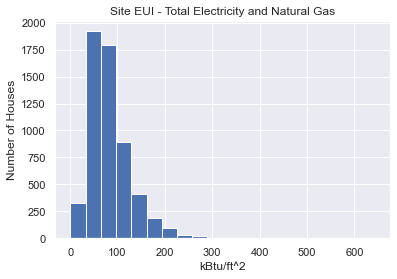

In [7]:
# Units are in kbtu
natural_gas = df['BTUNG'].values * 1.05 
eletricity = df['BTUEL'].values * 2.80
fuel = df['BTUFO'].values * 1.01
propane = df['BTULP'].values * 1.01

total_kbtu = df['TOTALBTU'].values / 1e3
ft2 = df['TOTSQFT_EN'].values

# total_kbtu = df['TOTALBTU']
eui = (natural_gas + eletricity + fuel + propane) / ft2 # kBtu/ft^2

fig, ax = plt.subplots()

ax.hist(eui, bins=20)
ax.set_title('Site EUI - Total Electricity and Natural Gas')
ax.set_xlabel('kBtu/ft^2')
ax.set_ylabel('Number of Houses')

## Regression analysis on EUI

Based on [ENERGY STAR Score technical reference](https://portfoliomanager.energystar.gov/pdf/reference/ENERGY%20STAR%20Score.pdf), the regression inputs should describe how the building operates rather then why building performs a certain way. 
* Hours, Workers, Floor Area, Computers, Weather
* Not - Lighting technology, energy price, etc. 

For our problem, we uses following informations
* Metropolis information, i.e. metropolitan/micropolitan, urban type
* Home specific factors i.e. year made, home types, square footage, basement, attics, rooms, etc. 
* Number of residences, children, etc. 
* Geographical weathers

In [8]:
reg_inputs = [
    # Urban?
    'METROMICRO', 
    'UATYP10',
    
    # Residential Type
    'TYPEHUQ',
    
    # Basement, Attic, & Garage? 
    'BASEFIN',
    'ATTIC', 
    'ATTICFIN',
    'PRKGPLC1',
    'SIZEOFGARAGE',
    
    # Year Made? 
    'YEARMADERANGE',
    
    # Number of Bedrooms/bathrooms, 
    'STUDIO',
    'BEDROOMS',
    'NCOMBATH',
    'NHAFBATH',
    'OTHROOMS',
    'TOTROOMS',
    
    # Weather
    'GWT', 'GNDHDD65', 'HDD65', 
    'HDD30YR', 'CDD65', 'CDD30YR', 
    'TEMPNITEAC', 'TEMPGONEAC', 
    'TEMPNITE', 'TEMPGONE', 
    
    # Total Squarefit? 
    'TOTSQFT_EN', 

    # Residenes?
    'NHSLDMEM',
    'NUMADULT', 
    'NUMCHILD', 
    'ATHOME'
]

dummy_inputs = [
    'METROMICRO', 
    'UATYP10',
    'TYPEHUQ'
]
df_reg = pd.get_dummies(df[reg_inputs], columns=dummy_inputs, drop_first=True)
df_reg = df_reg.replace({-2:0})
df_reg.describe()

,BASEFIN,ATTIC,ATTICFIN,PRKGPLC1,SIZEOFGARAGE,YEARMADERANGE,STUDIO,BEDROOMS,NCOMBATH,NHAFBATH,...,NUMCHILD,ATHOME,METROMICRO_MICRO,METROMICRO_NONE,UATYP10_R,UATYP10_U,TYPEHUQ_2,TYPEHUQ_3,TYPEHUQ_4,TYPEHUQ_5
count,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,...,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000
mean,0.188357,0.399930,0.063313,0.452163,0.855786,4.323954,0.020577,2.832923,1.746395,0.318326,...,0.605346,3.402744,0.102708,0.062786,0.204010,0.690820,0.659866,0.084242,0.054696,0.150897
std,0.391032,0.489927,0.243547,0.497750,1.019057,2.125081,0.141975,1.106412,0.747473,0.512265,...,1.040296,2.000603,0.303604,0.242599,0.403012,0.462196,0.473796,0.277775,0.227405,0.357980
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,2.000000,1.000000,0.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,3.000000,2.000000,0.000000,...,0.000000,5.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,2.000000,6.000000,0.000000,3.000000,2.000000,1.000000,...,1.000000,5.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,3.000000,8.000000,1.000000,10.000000,6.000000,4.000000,...,10.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Building regression model. 

In [9]:
X = df_reg.values
y = eui

pipe = Pipeline([
    ('poly', PolynomialFeatures(2, include_bias=False, interaction_only=True)),
    ('scaler', StandardScaler()),
    ('model', GammaRegressor(max_iter=1000))
])

params = {
    'model__alpha':np.exp(range(-5, 10))
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gs = GridSearchCV(pipe, params, scoring='r2', cv=5).fit(X, y)
    
gs.best_score_, gs.best_params_

(0.4756159897451431, {'model__alpha': 0.006737946999085467})

### Analysis on regression coefficients 

In [10]:
pipe = pipe.set_params(model__alpha=gs.best_params_['model__alpha'])
pipe.fit(X, y)

df_c = pd.DataFrame()
df_c['feature'] =gs.best_estimator_['poly'].get_feature_names(df_reg.columns.tolist())
df_c['coef'] = gs.best_estimator_['model'].coef_.ravel()
df_c['abs_coef'] = np.absolute(df_c['coef'])
df_c.sort_values('abs_coef', ascending=False)[['feature', 'abs_coef']].head(10)

C:\Users\dumps\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,abs_coef
22,TOTSQFT_EN,0.235515
386,GWT TOTSQFT_EN,0.220629
494,TEMPNITEAC TEMPGONEAC,0.198811
292,NCOMBATH TOTSQFT_EN,0.137570
402,GNDHDD65 CDD30YR,0.127617
266,BEDROOMS TOTSQFT_EN,0.121090
563,TOTSQFT_EN TYPEHUQ_5,0.117126
459,CDD65 CDD30YR,0.108207
377,GWT GNDHDD65,0.100746
407,GNDHDD65 TOTSQFT_EN,0.100455


The houses with  total square footage, weather conditions, and bathrooms impacts the EUI. 


In [11]:
# Prediction samples
eui_prd = pipe.predict(X)
list(zip(eui, eui_prd))[:5]

[(45.84894845132743, 75.02475717197366),
 (153.2216073781291, 130.0406467012552),
 (95.60223994755245, 94.19110808784502),
 (58.43426029537504, 56.19507333312703),
 (55.67854448242187, 113.74429386543116)]

## Energy Efficiency Ratio
The next step is to calculate energy efficiency ratio which represents the relative measure of how energy-efficient the home is by comparing the actual energy usage to expected energy usage. When the ratio is high, the residence building is less energy efficient, and vice versa.



Text(0, 0.5, 'House Count')

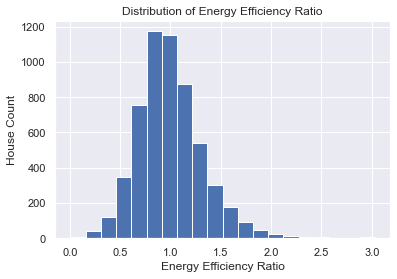

In [12]:
eer = eui/eui_prd
fig, ax = plt.subplots()

ax.hist(eer, bins=20)
ax.set_title('Distribution of Energy Efficiency Ratio')
ax.set_xlabel('Energy Efficiency Ratio')
ax.set_ylabel('House Count')

In [13]:
# Here we remove outliers. 
q = np.quantile(eer, 0.999)
np.sum(eer > q), q

(6, 2.8838414440915194)

In [14]:
outlier = eer > q
print('Ratio of outlier %f Number of outliers %d' % (np.sum(outlier)/len(df), np.sum(outlier)))
df = pd.read_csv('../../csv/recs2015_public_v4.csv')
df = df.loc[~outlier].reset_index(drop=True)
eer = eer[~outlier]
df['EER'] = eer

Ratio of outlier 0.001055 Number of outliers 6


## Clustering Analysis

To provide a fair score regardless of home-specific or geographical factors, we need to selects peers that are similar to each other based on "type 1" variables. In this analysis, we use hierarchical clustering algorithm. 

In [15]:
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', AgglomerativeClustering(n_clusters=None, 
                                      distance_threshold=0))
]).fit(X)

In [16]:
def plot_dendrogram(model, **kwargs):
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    
    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs)

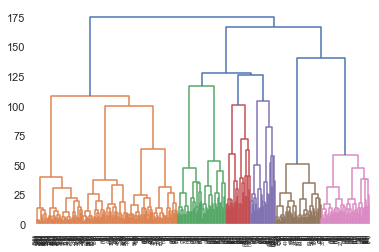

In [17]:
dendo = plot_dendrogram(pipe['model'], truncate_mode="level", p=8)

In [18]:
pipe = pipe.set_params(model__n_clusters=6, 
                       model__distance_threshold=None).fit(X)
labels = pipe['model'].labels_[~outlier]

Text(0, 0.5, 'Number of Houses')

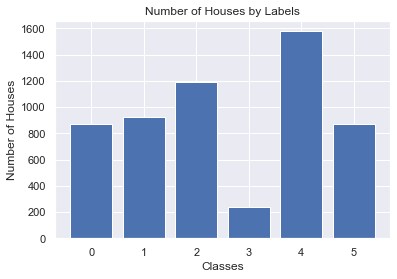

In [19]:
label_cls, counts = np.unique(labels, return_counts=True)

fig, ax = plt.subplots()

ax.bar(label_cls, counts)
ax.set_title('Number of Houses by Labels')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Houses')

In [20]:
df['LABEL'] = labels
df_grp = df[['LABEL'] + reg_inputs]\
    .groupby('LABEL')\
    .agg('mean')\
    .reset_index(drop=True).T\
    .reset_index()

pd.merge(df_grp, 
         df_codebook, 
         left_on='index', 
         right_on='Variable', how='left')[df_grp.columns.tolist() + ['Description']]

,index,0,1,2,3,4,5,Description
0,TYPEHUQ,2.759450,4.648649,2.020973,3.360996,1.963878,1.969001,Type of housing unit
1,BASEFIN,-1.194731,-2.000000,-1.046141,-1.987552,-0.367554,-1.851894,Finished basement
2,ATTIC,0.069874,-2.000000,0.041107,-0.817427,0.542459,0.518944,Attic above the housing unit
3,ATTICFIN,-1.302405,-2.000000,-1.231544,-1.535270,-0.569708,-0.838117,Finished attic
4,PRKGPLC1,0.197022,-2.000000,0.060403,-0.730290,0.558302,0.654420,Attached garage
5,SIZEOFGARAGE,-0.321879,-2.000000,-0.439597,-0.804979,0.469582,0.867968,Size of attached garage
6,YEARMADERANGE,4.163803,4.321081,4.372483,4.643154,3.952471,5.006889,Range when housing unit was built
7,STUDIO,-1.809851,0.102703,-1.904362,-1.070539,-2.000000,-2.000000,Studio apartment
8,BEDROOMS,2.620848,1.583784,2.987416,2.402490,3.349810,3.349024,Number of bedrooms
9,NCOMBATH,1.639175,1.241081,1.743289,1.668050,1.888466,2.160735,Number of full bathrooms


## Fitting Cumulative Distribution & Calculating Score

Once we have methods to classify the houses into its peer groups, we could now fit probability distributions on EUI for each group. Then, we could use the cumulative probability to generate a score between 0-100. 

$$
\begin{array} \left
 EER = \frac{EUI_{estimated}}{EUI_{actual}} \\
 Score = (1 - F_{gamma}(EER)) \times 100
\end{array}
$$

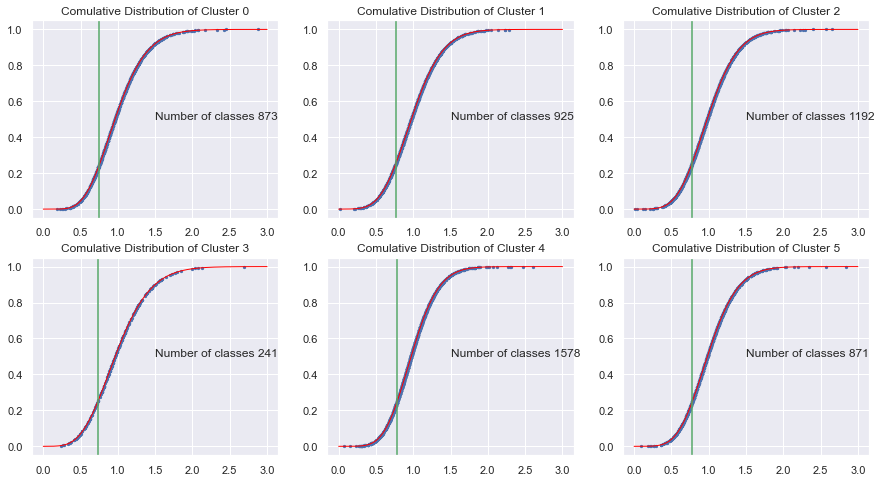

In [21]:
n_cls = len(label_cls)

alpha = np.empty(n_cls)
loc = np.empty(n_cls)
scale = np.empty(n_cls)

fig, axes = plt.subplots(2, n_cls//2, figsize=(15, 8))
axes = axes.ravel()

gs = []
vline = []
cds = np.empty(len(eer))

for i, cls in enumerate(label_cls):
    _eer = eer[labels == cls]
    alpha[i], loc[i], scale[i] = stats.gamma.fit(_eer)
    
    cd = stats.gamma.cdf(_eer, 
                         a = alpha[i], loc = loc[i], 
                         scale = scale[i])
    cds[labels == cls] = cd
    
    x = np.linspace(0, 3, 300)
    g = stats.gamma.cdf(x, a = alpha[i],loc=loc[i], scale=scale[i])
    gs.append(g)
    
    axes[i].plot(x, g, linewidth=1, c='red')
    axes[i].scatter(_eer, cd, s=5)
    axes[i].set_title('Comulative Distribution of Cluster %d' % (i))
    axes[i].text(1.5, 0.5, s='Number of classes %d' % len(_eer))
    
    idx = np.argmin(np.absolute(g - 0.25))
    vline.append(idx)
    axes[i].axvline(x[idx], c='g')
    
    
df['CD']= cds
df['SCORE'] = (1 - cds) * 100

0.25 EER std: 0.018 Relative Percentage: 0.006


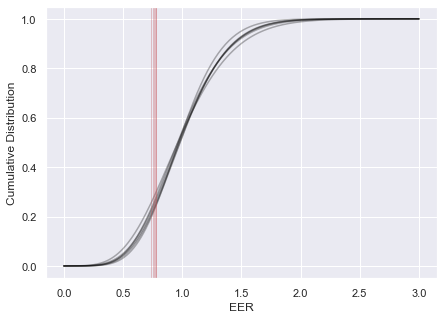

In [22]:
fig, ax = plt.subplots(figsize=(7, 5))

x = np.linspace(0, 3, 300)
ax.plot(x, 
        np.vstack(gs).T, c='black', alpha=0.3)
ax.set_xlabel('EER')
ax.set_ylabel('Cumulative Distribution')

for v in vline:
    ax.axvline(x[v], c= 'r', alpha=0.3, linewidth=1)
    
print('0.25 EER std: %.3f' % x[vline].std(), 'Relative Percentage: %.3f' % (x[vline].std() / 3))

## Looking into score

In [23]:
def agg_score(code, label=2):
    code_description(code)
    tmp = pquery(f"""
        SELECT {code}, AVG(SCORE) AS Score
        FROM df
        WHERE LABEL = {label}
        GROUP BY 1
    """)

    key = [int(k) for k in df_codebook[df_codebook['Variable'] == code]['Value'].item().split('\n')]
    val = df_codebook[df_codebook['Variable'] == code]['Value Description'].item().split('\n')

    cmap = dict(zip(key, val))

    tmp[code] = tmp[code].replace(cmap)

    return tmp

In [24]:
agg_score('ESDISHW')

Energy Star qualified dishwasher
1:Yes
0:No
-2:Not applicable
-8:Refused
-9:Don’t know


,ESDISHW,Score
0,Don’t know,47.877176
1,Refused,32.981788
2,Not applicable,51.711087
3,No,48.457412
4,Yes,52.372780


In [25]:
agg_score('ESFRIG')

Energy Star qualified refrigerator
1:Yes
0:No
-2:Not applicable
-8:Refused
-9:Don’t know


,ESFRIG,Score
0,Don’t know,48.345449
1,Refused,45.882156
2,Not applicable,71.953262
3,No,49.047277
4,Yes,52.381823


In [26]:
agg_score('ESWIN')

Energy Star qualified windows
1:Yes
0:No
-8:Refused
-9:Don’t know


,ESWIN,Score
0,Don’t know,48.870956
1,Refused,45.882156
2,No,49.304471
3,Yes,54.118091


In [27]:
agg_score('LPWATER')

Propane used for water heating
1:Yes
0:No


,LPWATER,Score
0,No,50.193858
1,Yes,53.642242
